In [ ]:
# Demo 4, problem 1, QFT
from numpy import pi
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
backend = Aer.get_backend("statevector_simulator")

# QFT for 2 qubits
qc = QuantumCircuit(2)

# Encode input bin 10 = dec 2
qc.x(1)

# Show input qubit and execute
statevector = execute(qc, backend=backend).result().get_statevector()
display(plot_bloch_multivector(statevector))

# Circuit for 2 qubit QFT
qc.h(1)
qc.cp(pi/2, 0, 1) 
qc.h(0)
qc.swap(0,1)
display(qc.draw('mpl'))

#Execute -> Output: Both vectors rotated 90 degs.
statevector = execute(qc, backend=backend).result().get_statevector()
display(plot_bloch_multivector(statevector))

# Same for 3 qubits
qc = QuantumCircuit(3)

# Encode input 101 = 5
qc.x(0)
qc.x(2)

# Show input qubit and execute
statevector = execute(qc, backend=backend).result().get_statevector()
display(plot_bloch_multivector(statevector))

# QFT for 3 qubits
qc.h(2)
qc.cp(pi/2, 1, 2) 
qc.cp(pi/4, 0, 2) 
qc.h(1)
qc.cp(pi/2, 0, 1) 
qc.h(0)
qc.swap(0,2)
display(qc.draw('mpl'))

#Execute -> Output: qubit 0 has been rotated by 5/8 of a full turn, qubit 1 by 1/4 of a full turn and qubit 2 by 1/2 of a full turn.
statevector = execute(qc, backend=backend).result().get_statevector()
display(plot_bloch_multivector(statevector))

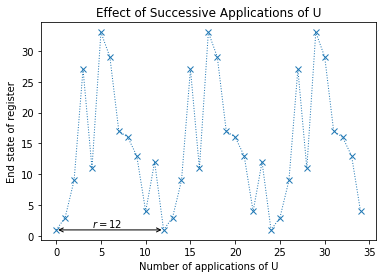

ValueError: 'a' must be 2,7,8,11 or 13

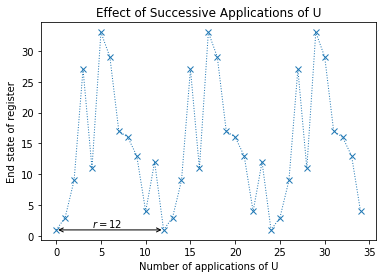

In [11]:
# Demo 4, problem 2, shor's algorithm
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

N = 35
a = 3

# Calculate the plotting data
xvals = np.arange(N)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) +1 
    plt.annotate(text='', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='$r=%i$' % r, xy=(r/3,1.5))
except:
    print('Could not find period, check a < N and have no common factors.')
    
ax.set(xlabel='Number of applications of U', ylabel='End state of register',
       title="Effect of Successive Applications of U")
display(fig)

def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

# Specify variables
n_count = 8 # number of counting qubits
a = 3

def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialise counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And ancilla register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
display(qc.draw('text'))

backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, shots=2048).result()
counts = results.get_counts()
display(plot_histogram(counts))

rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count) # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append(["%s(bin) = %i(dec)" % (output, decimal), 
                 "%i/%i = %.2f" % (decimal, 2**n_count, phase)])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for i in range(j):
        a = np.mod(a**2, N)
    return a

a2jmodN(3, 2049, 53)

N = 15

from math import gcd # greatest common divisor
gcd(a, 15)

def qpe_amod15(a):
    n_count = 3
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialise counting qubits in state |+>
    qc.x(3+n_count) # And ancilla register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    backend = Aer.get_backend('qasm_simulator')
    # Setting memory=True below allows us to see a list of each sequential reading
    result = execute(qc, backend, shots=1, memory=True).result()
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

np.random.seed(3) # This is to make sure we get reproduceable results
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15) # Denominator should (hopefully!) tell us r

frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

a = 3
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(15) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, 15), gcd(a**(r//2)+1, 15)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess != 1 and (15 % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True

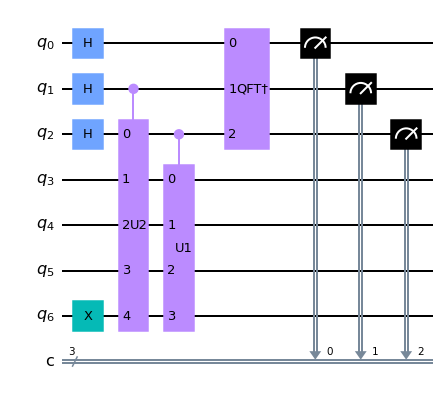

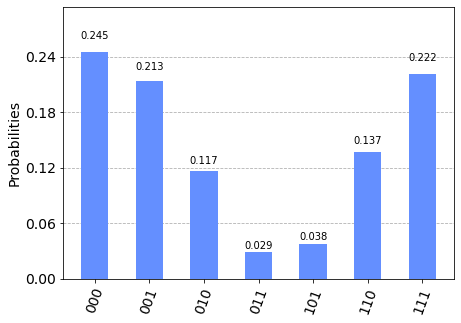

     Register Output       Phase
0  000(bin) = 0(dec)  0/8 = 0.00
1  001(bin) = 1(dec)  1/8 = 0.12
2  010(bin) = 2(dec)  2/8 = 0.25
3  011(bin) = 3(dec)  3/8 = 0.38
4  101(bin) = 5(dec)  5/8 = 0.62
5  110(bin) = 6(dec)  6/8 = 0.75
6  111(bin) = 7(dec)  7/8 = 0.88
   Phase Fraction  Guess for r
0  0.000      0/1            1
1  0.125      1/8            8
2  0.250      1/4            4
3  0.375      3/8            8
4  0.625      5/8            8
5  0.750      3/4            4
6  0.875      7/8            8


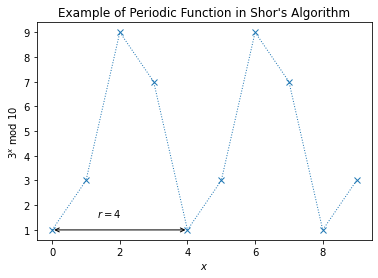

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
import matplotlib.pyplot as plt

N = 10
a = 3

# Calculate the plotting data
xvals = np.arange(10)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) +1 
    plt.annotate(text='', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate(text='$r=%i$' % r, xy=(r/3,1.5))
except:
    print('Could not find period, check a < N and have no common factors.')
    
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

def U2():
    """Controlled multiplication by 9 mod 10"""
    U = QuantumCircuit(5)   
    U.x(3)
    U = U.to_gate()
    U.name = "U2" 
    c_U = U.control()
    return c_U

def U1():
    """Controlled multiplication by 9 mod 10"""
    U = QuantumCircuit(4)   
    U.x(1)
    U.swap(3,2)
    U = U.to_gate()
    U.name = "U1" 
    c_U = U.control()
    return c_U

# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
n_count = 3
act_qubits = 4
qc = QuantumCircuit(n_count + act_qubits, n_count)

# Initialise counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And ancilla register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
qc.append(U2(), range(n_count-1-1,n_count+act_qubits))
qc.append(U1(), range(n_count-1,n_count+act_qubits))

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
display(qc.draw('mpl'))

backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, shots=2048).result()
counts = results.get_counts()
display(plot_histogram(counts))

rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count) # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append(["%s(bin) = %i(dec)" % (output, decimal), 
                 "%i/%i = %.2f" % (decimal, 2**n_count, phase)])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (frac.numerator, frac.denominator), frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)